In [1]:
import pandas as pd
import numpy as np
import sqlite3
from datetime import datetime
import time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from math import floor, ceil
from pylab import rcParams
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import csv
from torch.autograd import Variable

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
import lstm, time

%matplotlib inline
engine = sqlite3.connect('DB')

Using TensorFlow backend.
/Users/CraigFan/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#Write code to convert CSV to Pandas. Pretty sure I lost it somewhere
test = pd.read_csv('./test.csv')
baseTrain = pd.read_csv('./train.csv')
featuresDf = pd.read_csv('./features.csv')

In [3]:
#Combining training data with the features
storesWithTrain = pd.read_sql("""
SELECT *
FROM trainDf
JOIN storesDf 
ON storesDf.Store = trainDf.Store
""", engine)
#Removes duplicate columns
_, i = np.unique(storesWithTrain.columns, return_index = True)
storesWithTrain = storesWithTrain.iloc[:, i]
storesWithTrain.to_sql('storesWithTrain', engine, if_exists='replace', index = False)

everything = pd.read_sql("""
SELECT *
FROM storesWithTrain
JOIN featuresDf
ON storesWithTrain.Store = featuresDf.Store AND storesWithTrain.Date = featuresDf.Date
""", engine)

#Get all unique elements
_, i = np.unique(everything.columns, return_index = True)
everything = everything.iloc[:, i]

In [6]:
#Grabbing just the basic features that match with the testing data
baseTrain_y = baseTrain['Weekly_Sales']
baseTrain_x = baseTrain.drop('Weekly_Sales', axis = 1)
baseTrain_x['Date'] = baseTrain_x['Date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
baseTrainDate_x = baseTrain_x
baseTrainDate_x.to_sql('baseTrainDate_x', engine, if_exists='replace', index = False)

baseTrain_x['Date'] = baseTrain_x['Date'].apply(lambda x: int(time.mktime(x.timetuple())) / 1000000)

In [40]:
#Cleaning the data that has everything

#Parsing the data/convert data time to milliseconds
train_x = everything.drop_duplicates()
train_x = train_x.dropna().reset_index(drop = True)#Get rid of this line if you don't want to drop NaN

#Convert date string to date time object to get milliseconds
train_x['Date'] = train_x['Date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
train_x['Date'] = train_x['Date'].apply(lambda x: int(time.mktime(x.timetuple())) / 1000000)

test['Date'] = test['Date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
test['Date'] = test['Date'].apply(lambda x: int(time.mktime(x.timetuple())) / 1000000)

train_y = train_x['Weekly_Sales']
train_y = train_y.to_frame()
train_y = train_y.dropna().reset_index(drop = True)
train_x.drop('Weekly_Sales', axis = 1, inplace = True)

In [41]:
#Optional cell if you want to remove NaNs. This will mainly remove the MarkDown rows
#One hot code for everything data
storeType = train_x['Type']
encoding = pd.get_dummies(storeType)

train_x['A'] = encoding['A']
train_x['B'] = encoding['B']
train_x['C'] = encoding['C']
train_x.drop('Type', axis = 1, inplace = True)
train_x = train_x.dropna().reset_index(drop = True)

In [42]:
train_x.to_sql('train_x', engine, if_exists = 'replace', index = False)
train_y.to_sql('train_y', engine, if_exists = 'replace', index = False)
test.to_sql('test', engine, if_exists='replace', index = False)
baseTrain_x.to_sql('baseTrain_x', engine, if_exists='replace', index = False)
baseTrain_y.to_sql('baseTrain_y', engine, if_exists='replace', index = False)

In [ ]:
train_df = pd.read_csv('./train.csv')

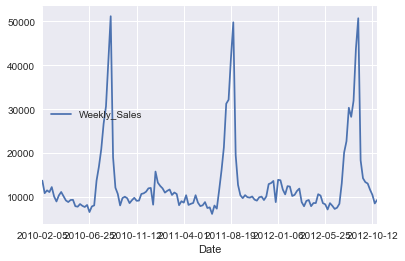

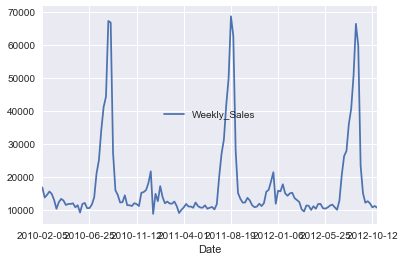

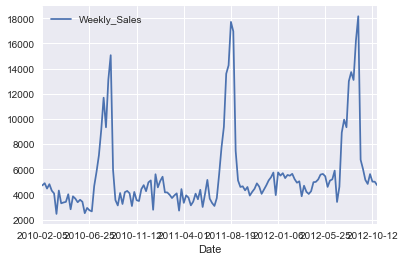

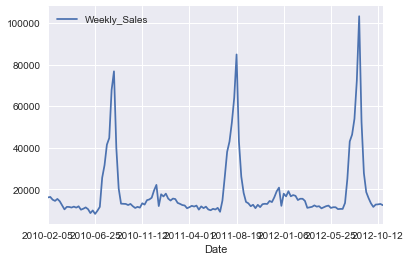

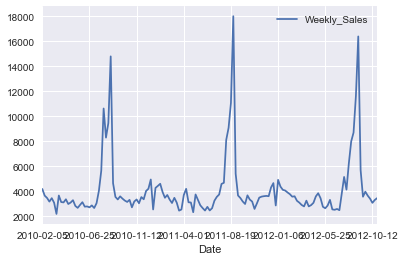

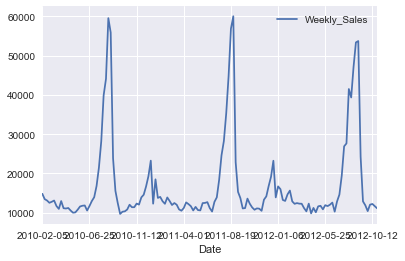

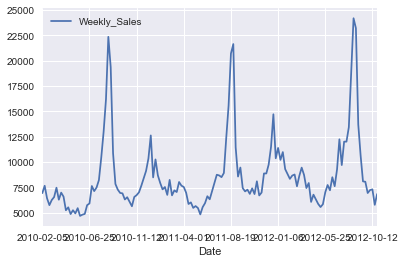

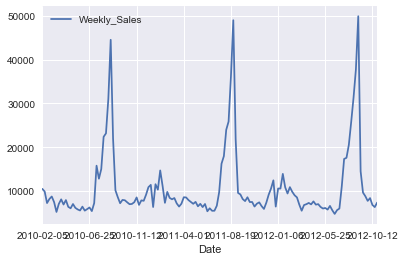

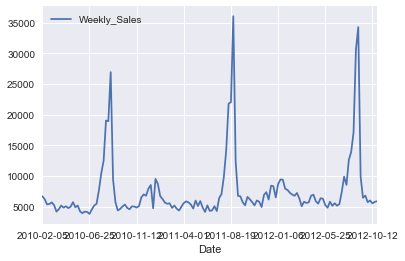

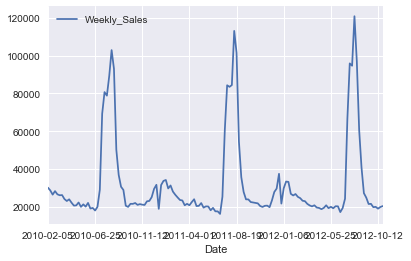

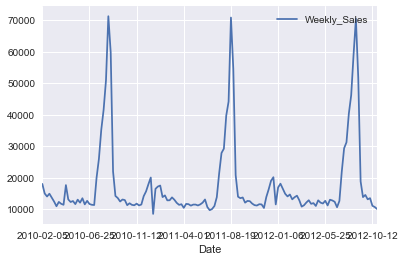

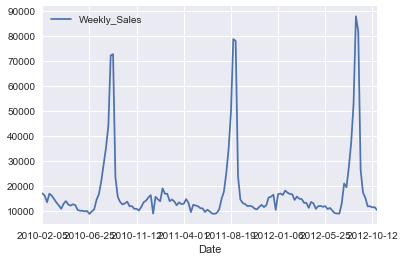

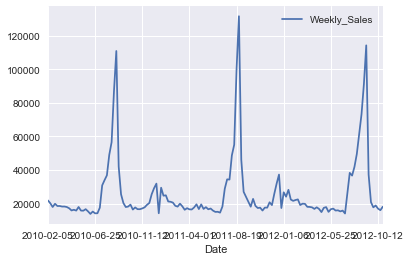

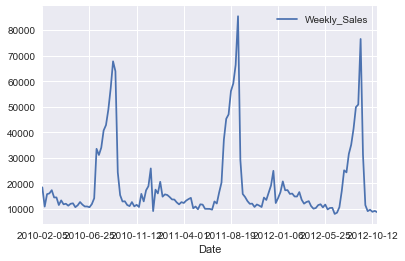

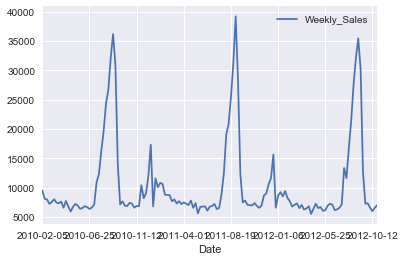

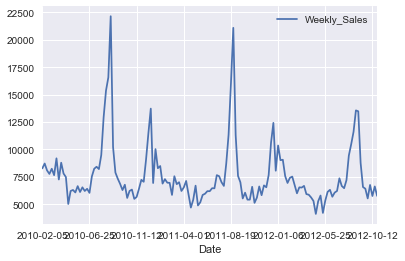

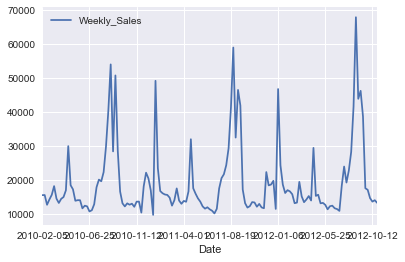

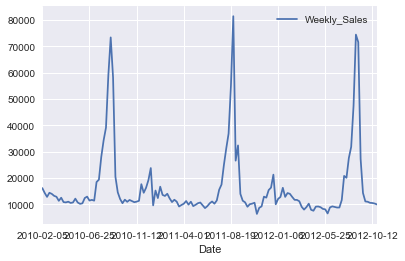

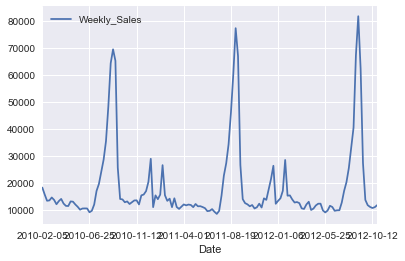

In [26]:
for i in range(1, 20):
    train_df[(train_df['Store'] == i) & (train_df['Dept'] == 3)].plot(x = 'Date', y = 'Weekly_Sales')

In [11]:
everything = everything.drop_duplicates()
#everything = everything.dropna().reset_index(drop = True)

storeType = everything['Type']
encoding = pd.get_dummies(storeType)

everything['A'] = encoding['A']
everything['B'] = encoding['B']
everything['C'] = encoding['C']
everything.drop('Type', axis = 1, inplace = True)
#everything = everything.dropna().reset_index(drop = True)

In [37]:
all_Data_Train_Y = everything['Weekly_Sales'].to_frame()
all_Data_Train_X = everything.drop('Weekly_Sales', axis = 1)

all_Data_Train_X['Date'] = all_Data_Train_X['Date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

all_Data_Train_Time_X = all_Data_Train_X

all_Data_Train_Time_X['A'] = encoding['A']
all_Data_Train_Time_X['B'] = encoding['B']
all_Data_Train_Time_X['C'] = encoding['C']

all_Data_Train_Time_X = all_Data_Train_Time_X.fillna(0)
all_Data_Train_Time_X['MarkDown1'] = all_Data_Train_Time_X['MarkDown1'].replace(to_replace = 0.00, value = markDown1Avg)
all_Data_Train_Time_X['MarkDown2'] = all_Data_Train_Time_X['MarkDown2'].replace(to_replace = 0.00, value = markDown2Avg)
all_Data_Train_Time_X['MarkDown3'] = all_Data_Train_Time_X['MarkDown3'].replace(to_replace = 0.00, value = markDown3Avg)
all_Data_Train_Time_X['MarkDown4'] = all_Data_Train_Time_X['MarkDown4'].replace(to_replace = 0.00, value = markDown4Avg)
all_Data_Train_Time_X['MarkDown5'] = all_Data_Train_Time_X['MarkDown1'].replace(to_replace = 0.00, value = markDown5Avg)
all_Data_Train_Time_X.to_sql('all_Data_Train_Time_X', engine, if_exists='replace', index = False)

In [40]:
all_Data_Train_Time_X['Date'][0]

Timestamp('2010-02-05 00:00:00')

In [38]:
temp = pd.read_sql("""
SELECT *
FROM all_Data_Train_Time_X
""", engine)
temp['Date'][0]

'2010-02-05 00:00:00'

In [43]:
all_Data_Train_X['Date'] = all_Data_Train_X['Date'].apply(lambda x: int(time.mktime(x.timetuple())) / 1000000)

all_Data_Train_X = all_Data_Train_X.fillna(0)

markDown1Avg = all_Data_Train_X['MarkDown1'].mean()
markDown2Avg = all_Data_Train_X['MarkDown2'].mean()
markDown3Avg = all_Data_Train_X['MarkDown3'].mean()
markDown4Avg = all_Data_Train_X['MarkDown4'].mean()
markDown5Avg = all_Data_Train_X['MarkDown5'].mean()
print(markDown1Avg, markDown2Avg, markDown3Avg, markDown4Avg, markDown5Avg)
all_Data_Train_X['MarkDown1'] = all_Data_Train_X['MarkDown1'].replace(to_replace = 0.00, value = markDown1Avg)
all_Data_Train_X['MarkDown2'] = all_Data_Train_X['MarkDown2'].replace(to_replace = 0.00, value = markDown2Avg)
all_Data_Train_X['MarkDown3'] = all_Data_Train_X['MarkDown3'].replace(to_replace = 0.00, value = markDown3Avg)
all_Data_Train_X['MarkDown4'] = all_Data_Train_X['MarkDown4'].replace(to_replace = 0.00, value = markDown4Avg)
all_Data_Train_X['MarkDown5'] = all_Data_Train_X['MarkDown1'].replace(to_replace = 0.00, value = markDown5Avg)

AttributeError: 'float' object has no attribute 'timetuple'

In [42]:
all_Data_Train_X

,CPI,Date,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Size,Store,Temperature,Unemployment,A,B,C
0,211.096358,12.653460,1,2.572,0,2590.074819,879.974298,468.087665,1083.132268,2590.074819,151315,1,42.31,8.106,1,0,0
1,211.242170,12.659508,1,2.548,1,2590.074819,879.974298,468.087665,1083.132268,2590.074819,151315,1,38.51,8.106,1,0,0
2,211.289143,12.665556,1,2.514,0,2590.074819,879.974298,468.087665,1083.132268,2590.074819,151315,1,39.93,8.106,1,0,0
3,211.319643,12.671604,1,2.561,0,2590.074819,879.974298,468.087665,1083.132268,2590.074819,151315,1,46.63,8.106,1,0,0
4,211.350143,12.677652,1,2.625,0,2590.074819,879.974298,468.087665,1083.132268,2590.074819,151315,1,46.50,8.106,1,0,0
5,211.380643,12.683700,1,2.667,0,2590.074819,879.974298,468.087665,1083.132268,2590.074819,151315,1,57.79,8.106,1,0,0
6,211.215635,12.689712,1,2.720,0,2590.074819,879.974298,468.087665,1083.132268,2590.074819,151315,1,54.58,8.106,1,0,0
7,211.018042,12.695760,1,2.732,0,2590.074819,879.974298,468.087665,1083.132268,2590.074819,151315,1,51.45,8.106,1,0,0
8,210.820450,12.701808,1,2.719,0,2590.074819,879.974298,468.087665,1083.132268,2590.074819,151315,1,62.27,7.808,1,0,0
9,210.622857,12.707856,1,2.770,0,2590.074819,879.974298,468.087665,1083.132268,2590.074819,151315,1,65.86,7.808,1,0,0


In [ ]:
rawTest = pd.read_csv('./test.csv')
rawTest.to_sql('rawTest', engine, if_exists='replace', index = False)

In [49]:
all_Data_Test = pd.read_sql("""
SELECT *
FROM rawTest
JOIN featuresDf 
ON featuresDf.Date = rawTest.Date AND featuresDf.Store = rawTest.Store
""", engine)

_, i = np.unique(all_Data_Test.columns, return_index=True)
all_Data_Test = all_Data_Test.iloc[:, i]

all_Data_Test.to_sql('all_Data_Test', engine, if_exists='replace', index = False)

all_Data_Test = pd.read_sql("""
SELECT *
FROM all_Data_Test
JOIN storesDf 
ON storesDf.Store = all_Data_Test.Store
""", engine)

_, i = np.unique(all_Data_Test.columns, return_index=True)
all_Data_Test = all_Data_Test.iloc[:, i]

storeType = all_Data_Test['Type']
encoding = pd.get_dummies(storeType)

all_Data_Test['A'] = encoding['A']
all_Data_Test['B'] = encoding['B']
all_Data_Test['C'] = encoding['C']
all_Data_Test.drop('Type', axis = 1, inplace = True)
#all_Data_Test = all_Data_Test.dropna().reset_index(drop = True)

all_Data_Test['Date'] = all_Data_Test['Date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
all_Data_Test['Date'] = all_Data_Test['Date'].apply(lambda x: int(time.mktime(x.timetuple())) / 1000000)
all_Data_Test = all_Data_Test.fillna(0)

markDown1Avg = all_Data_Test['MarkDown1'].mean()
markDown2Avg = all_Data_Test['MarkDown2'].mean()
markDown3Avg = all_Data_Test['MarkDown3'].mean()
markDown4Avg = all_Data_Test['MarkDown4'].mean()
markDown5Avg = all_Data_Test['MarkDown5'].mean()
print(markDown1Avg, markDown2Avg, markDown3Avg, markDown4Avg, markDown5Avg)
all_Data_Test['MarkDown1'] = all_Data_Test['MarkDown1'].replace(to_replace = 0.00, value = markDown1Avg)
all_Data_Test['MarkDown2'] = all_Data_Test['MarkDown2'].replace(to_replace = 0.00, value = markDown2Avg)
all_Data_Test['MarkDown3'] = all_Data_Test['MarkDown3'].replace(to_replace = 0.00, value = markDown3Avg)
all_Data_Test['MarkDown4'] = all_Data_Test['MarkDown4'].replace(to_replace = 0.00, value = markDown4Avg)
all_Data_Test['MarkDown5'] = all_Data_Test['MarkDown1'].replace(to_replace = 0.00, value = markDown5Avg)

7679.259430230031 2805.049618820663 2197.8119635160524 2980.2982673117026 3922.6811887297163


In [50]:
all_Data_Train_X.to_sql('all_Data_Train_X', engine, if_exists='replace', index = False)
all_Data_Train_Y.to_sql('all_Data_Train_Y', engine, if_exists='replace', index = False)
all_Data_Test.to_sql('all_Data_Test', engine, if_exists='replace', index = False)

In [130]:
regr = RandomForestRegressor()
regr.fit(all_Data_Train_X, all_Data_Train_Y)

/Users/CraigFan/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [131]:
submissionTest = pd.read_csv('./test.csv')
def createId(row):
    return str(row['Store']) + '_' + str(row['Dept']) + '_' + str(row['Date'])
submissionTest['Id'] = submissionTest.apply(lambda row: createId(row), axis = 1)

In [132]:
def createSubmissionFile(submissionTest, predictions):
    index = []
    for i in range(len(predictions)):
        index.append(i + 1)

    predictionToCSV = np.asarray(predictions)
    indexToCSV = np.asarray(index)

    combined = []
    for i in range(len(predictions)):
        combined.append([submissionTest['Id'].iloc[i], predictionToCSV[i]])

    combined = np.asarray(combined)
    np.savetxt('predictions.csv', combined, delimiter = ",", header = 'Id,Weekly_Sales', fmt = '%s')

predictions = regr.predict(all_Data_Test)
createSubmissionFile(submissionTest, predictions)
